# Volatility Arbitrage Strategy

In [3]:
# import necessary libraries
import pandas as pd

# import class object under Code folder
from Code.data_cleaning import data_cleaning
from Code.implied_vol import BS_implied_vol

## Data Cleaning

- retrieve spx option data from Bloomberg
- retrieve spx index data from yhoo finance
- clean data
  - unnecessary rows and columns
  - option ticker breakdown
  - expiration date format
  - keep options with certain expiration date which have more than 10 implied volatility
  - save the term structure of options
  - use the mid price of bid and ask as the option price
  - only use SPX data not SPXW data


In [4]:
raw_data = pd.read_csv('./Public/data/option_price/20230901/spx_option_0901.csv')
option_data = data_cleaning(raw_data).format_data()
option_data = data_cleaning(option_data).check_iv_number()
spx_data = data_cleaning(option_data).get_spx_hist('2021-09-01', '2023-11-13')
option_price = data_cleaning(option_data).extract_option_price()
display(option_data.head())
display(spx_data.head())
display(option_price.head())

,Ticker,Index,Type,Expiry,Strike,Bid,Ask,Last,Volm,IVM
0,SPX 9/15/23 C4470,SPX,C,2023-09-15,4470,66.699997,67.699997,68.380005,16.0,10.665597
1,SPX 9/15/23 C4475,SPX,C,2023-09-15,4475,62.900009,63.900009,61.449997,18.0,10.570473
2,SPX 9/15/23 C4480,SPX,C,2023-09-15,4480,59.100006,60.199997,53.169998,6.0,10.464067
3,SPX 9/15/23 C4490,SPX,C,2023-09-15,4490,52.000000,53.000000,52.119995,11.0,10.279760
4,SPX 9/15/23 C4495,SPX,C,2023-09-15,4495,48.599991,49.599991,48.669998,6.0,10.197698


,Open
Date,
2021-09-01,4528.799805
2021-09-02,4534.479980
2021-09-03,4532.419922
2021-09-07,4535.379883
2021-09-08,4518.089844


,Strike,Expiry,c,p
0,4470,2023-09-15,67.199997,16.199997
1,4475,2023-09-15,63.400009,17.400002
2,4480,2023-09-15,59.650002,18.649994
3,4490,2023-09-15,52.500000,21.449997
4,4495,2023-09-15,49.099991,23.000000


## Find BS Implied Volatility

- use put-call parity to calculate the risk-free rate and dividend yield for spx index option
  - for different expiration date, the implied risk-free rate are different. 
    $$
    C-P = S_0e^{-qT}-Ke^{-rT}\\
    C-P = e^{-rT}(S_0e^{(r-q)T}-K) = e^{-rT}(F_{(0, T)}-K)\\
    \text{where }F_{(0,T)}:=S_0e^{(r-q)T}, \text{ which is the forward price at time 0 with maturity T. }
    $$
  - get rid of outlier and abnormal value, implied risk-free rate are the average of the rest
    $$
      r_{risk-free, implied} = \frac{1}{N}\sum_{i=1}^N r_i, \quad r_i \in [r_{min}, r_{max}]
    $$
- use Black-Scholes model to calculate the implied volatility for each option
  - Black-Scholes model using forward price, the formula is:
    $$
    C(t) = e^{-r(T-t)}(F_{(t, T)}\Phi(d_1)-K\Phi(d_2))\\
    P(t) = e^{-r(T-t)}(K\Phi(-d_2)-F_{(t, T)}\Phi(-d_1))\\
    \displaystyle\text{where }d_1 = \frac{\ln(\frac{F_{(t, T)}}{K})+\frac{1}{2}\sigma^2T}{\sigma\sqrt{T}},\quad d_2 = d_1-\sigma\sqrt{T}, \quad \phi() \text{ is the standard normal pdf}\\
    \text{and }F_{(t, T)}:=S_0e^{(r-q)(T-t)}, \text{ which is the forward price at time 0 with maturity T. }
    
    $$
  - Use bisection method to get the implied volatility.   
    $$
      \sigma_{implied}(F_{(0, T)}, K, T, r, c) = \sigma_{implied}(F_{(0, T)}, K, T, r, p)\\
    $$

- Calculate forward moneyness for each option
  $$
  \text{forward moneyness} = \ln\left(\frac{K}{F_{(0,T)}}\right)
  $$


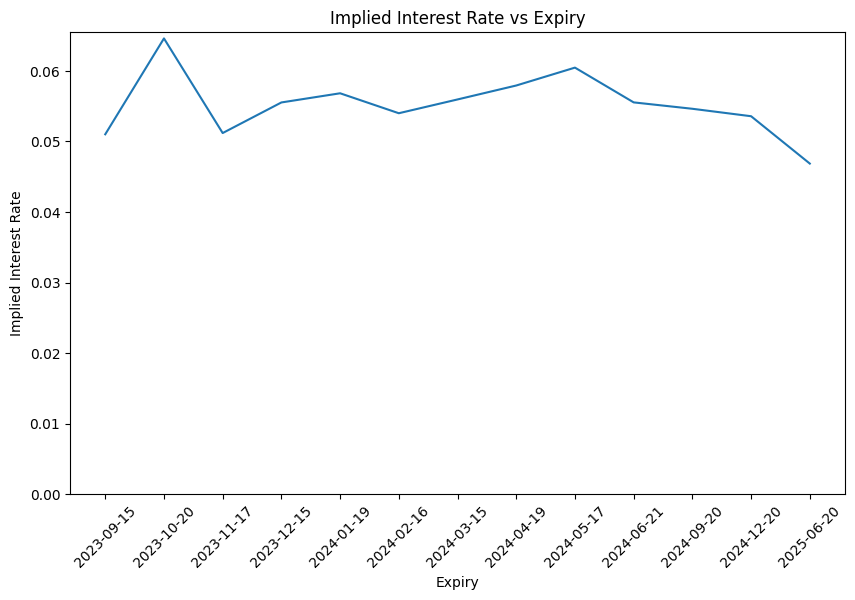

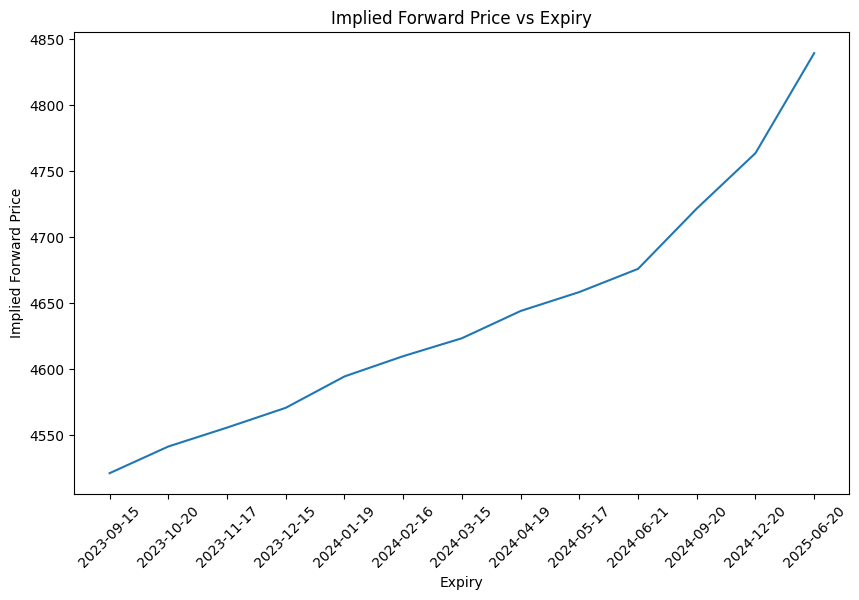

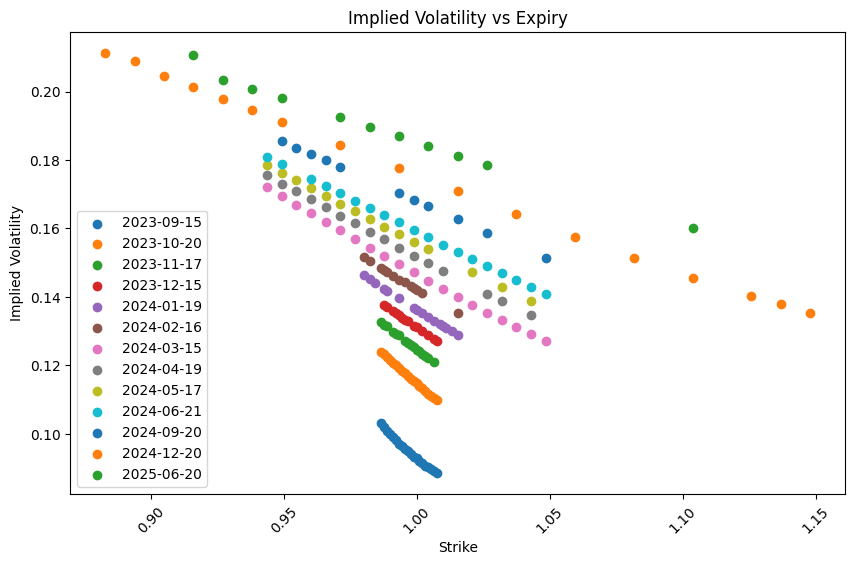

,Expiry,implied_ir,implied_fwd
0,2023-09-15,0.051018,4521.108973
1,2023-10-20,0.064610,4541.316310
2,2023-11-17,0.051196,4555.638916
3,2023-12-15,0.055533,4570.635823
4,2024-01-19,0.056832,4594.397578


Put Call Parity Implied Interest Rate: 0.0552


In [5]:
implied_params = BS_implied_vol(option_price).parity_implied_params(option_data, plot_parity=False)
BS_implied_vol(option_price).plot_ir(implied_params)
BS_implied_vol(option_price).plot_fwd(implied_params)
r = BS_implied_vol(option_price).get_ir(implied_params)
implied_vol = BS_implied_vol(option_price).get_iv(option_data, implied_params, spx_data, r, plot_iv_scatter=True)
display(implied_params.head())
print(f'Put Call Parity Implied Interest Rate: {r:.4f}')

## Fit BS Implied Volatility Surface

- calculate the implied volatility for each option using the implied volatility of the at-the-money option with the same expiration date
- for the same expiration date, fit the implied volatility curve against spot moneyness using function below:
  - option 1: similar to tanh function
    $$
    \sigma(x)^2 = \sigma_{atm}^2 + \delta\displaystyle\left(\frac{\tanh(\kappa x)}{\kappa}\right) + \frac{\gamma}{2}\left(\frac{\tanh(\kappa x)}{\kappa}\right)^2,\quad
    \text{where }x = \displaystyle\ln\left(\frac{K}{S}\right)
    $$
  - option 2: similar to sigmoid function
- for different expiration date, for same moneyness, connect the implied volatility curve using cubic spline interpolation


In [17]:
# get the at the money forawrd


## Convert BS Implied Volatility Surface to Local Volatility Surface

- use Dupire's formula to calculate the local volatility for each option
  $$
  \frac{\partial w}{\partial T} = v_L \left\{1 - \frac{y}{w}\frac{\partial w}{\partial y} + \frac{1}{4}\left(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2}\right)\left(\frac{\partial w}{\partial y}\right)^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}\right\}\\
  \text{where }w:=\text{ Black-Scholes implied variance},\quad y:= \ln\left(\frac{K}{F_T}\right), \quad v_L:=\text{ local volatility}
  $$

## Trading Strategy

- if the implied volatility of an option is higher than the local volatility, then sell the option

## Backtesting

# To-do List
- after delete the rows with 0 volume, the moneyness with near expiration date is close to 0, it is hard to fit the implied volatility curve
- put call parity last price in 2023-09-15, the interest rate is negative. Using last price to calculate the risk-free rate fluctuates a lot. 
- if use put-call parity to get interest rate and forward price, what is the Dupire's formula?  
- how to use spot moneyness to fit the implied volatility curve?
- implied forawrd price is not a linear line. Is there anything wrong?

# Reference

[How to Determine Implied Dividend Yield-Derivative Valuation in Excel](https://derivvaluation.medium.com/how-to-determine-implied-dividend-yield-derivative-valuation-in-excel-1078a9bc1f7f)  
[SPX vs. SPXW Options: Understanding the Key Differences](https://insideoptions.io/spx-spxw-options-differences/)  
[Cubic Spline Interpolation](https://en.wikipedia.org/wiki/Spline_interpolation#Algorithm_to_find_the_interpolating_cubic_spline)  
[Estimation of Implied Interest Rates and Dividend Yields](../volatility_arbitrage/Reference/on_a_robust_estimation_of_option-implied_interest_rates_and_dividend_yields.pdf)  
[Put-Call-Forward Parity](https://analystnotes.com/cfa-study-notes-explain-put-call-forward-parity-for-european-options.html)  
[At-The-Money-Forward option approximation](https://quant.stackexchange.com/questions/35433/at-the-money-forward-option-approximation)